# Metrics

In [1]:
!pip install pyloudnorm torchmetrics ipywidgets

In [3]:
path_to_dataset = '/home/mac-mvak/code_disk/hw2/data/datasets/librispeech/train-clean-360'

In [33]:
import os
import glob
from glob import glob

import numpy as np

import random
import json

import librosa
import soundfile as sf
import pyloudnorm as pyln
import matplotlib.pyplot as plt

import torch
from torchmetrics.audio import SignalDistortionRatio, ScaleInvariantSignalDistortionRatio
from IPython import display

from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings("ignore")

There are three main scores to evaluate source to noise ratio:

- SNR(Signal-To-Noise Ratio).
\begin{gather*}
    SNR(s, \hat{s}) = 10 \log_{10}{\|s\|^2 \over \|s - \hat{s}\|^2}
\end{gather*}

- SDR(Signal-To-Distortion Ratio, https://inria.hal.science/inria-00544230/document).
For decomposition
\begin{gather*}
    \hat{s} = s + \varepsilon^{\rm{spat}} + \varepsilon^{\rm{interf}} + \varepsilon^{\rm{artif}}
\end{gather*}
the SDR score looks like
\begin{gather*}
    SDR(\hat{s}, s) = 10 \log_{10}{\|\hat{s}\|^2 \over \|\varepsilon^{\rm{spat}} + \varepsilon^{\rm{artif}}\|^2}
\end{gather*}


- SI-SDR(Scale-Invariant Signal-To-Distortion Ratio, https://browse.arxiv.org/pdf/1811.02508.pdf).
\begin{gather*}
    SI\text{-}SDR(\hat{s}, s) = 10 \log_{10}{\|{\hat{s}^T s \over \|s\|^2}s\|^2 \over \|{\hat{s}^T s \over \|s\|^2}s - \hat{s}\|^2}
\end{gather*}

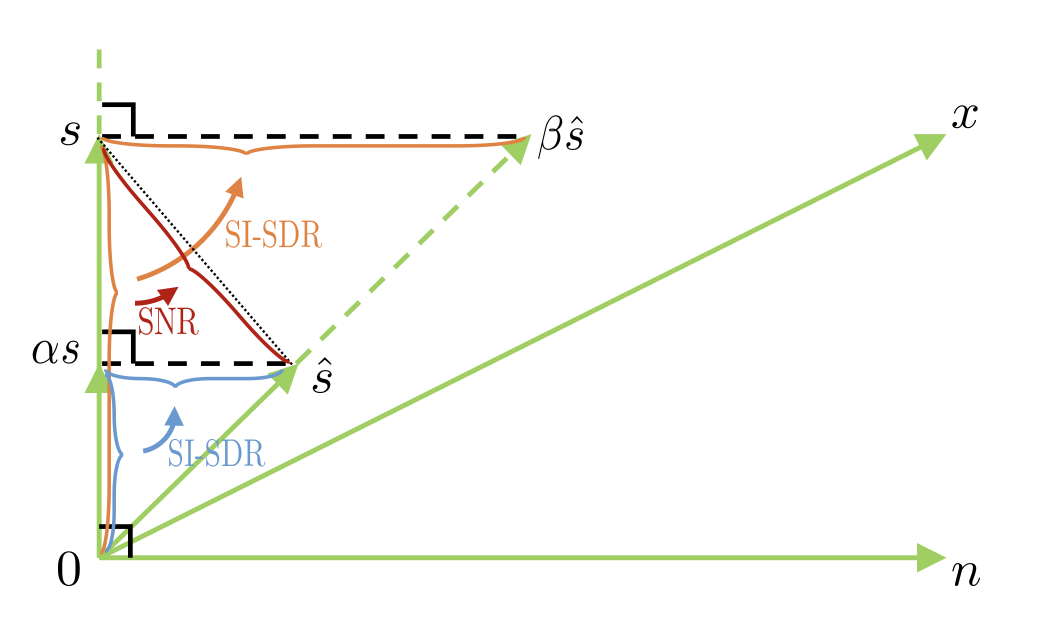

In [5]:
def snr(est, target):
    return 20 * np.log10(np.linalg.norm(target) / (np.linalg.norm(target - est) + 1e-6) + 1e-6)

def si_sdr(est, target):
    alpha = (target * est).sum() / np.linalg.norm(target)**2
    return 20 * np.log10(np.linalg.norm(alpha * target) / (np.linalg.norm(alpha * target - est) + 1e-6) + 1e-6)

In [8]:
target, _ = sf.read('/home/mac-mvak/code_disk/hw2/data/datasets/librispeech/train-clean-360/17/362/17-362-0000.flac')
noise, _ = sf.read('content/Vacuum2.wav')

meter = pyln.Meter(16000) # create BS.1770 meter

louds = meter.integrated_loudness(noise)
noise = pyln.normalize.loudness(noise, louds, -29)

In [9]:
length = min(len(target), len(noise))

target = target[:length]
noise = noise[:length]
s1 = target + noise
display.display(display.Audio(s1, rate=16000))

#Compute SNR

snr_val = snr(s1, target)
print(snr_val)

-1.2374575055745836


In [10]:
s2 = (target + noise) * 10
display.display(display.Audio(s2, rate=16000))

snr_val = snr(s2, target)
print(snr_val)

-23.296994934777334


In [11]:
sdr = SignalDistortionRatio()

print("SDR for s1:", sdr(torch.from_numpy(s1), torch.from_numpy(target)).item())
print("SDR for s2:", sdr(torch.from_numpy(s2), torch.from_numpy(target)).item())
print("SI-SDR for s1:", si_sdr(s1, target))
print("SI-SDR for s2:", si_sdr(s2, target))

SDR for s1: -1.2367255687713623
SDR for s2: -1.2367255687713623
SI-SDR for s1: -1.2525788057359457
SI-SDR for s2: -1.2525782749087633


In [12]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(window_size)

spectrum = torch.stft(
    torch.from_numpy(s1),
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,
    center=False,
    onesided=True,
    return_complex=False,
)

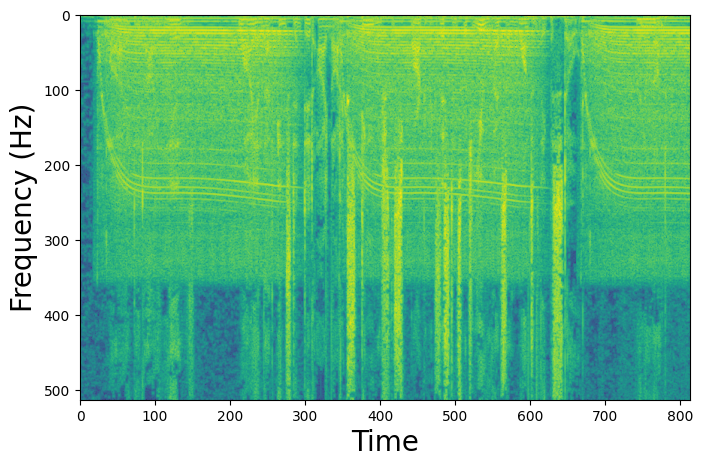

In [13]:
spectrogram = spectrum.norm(dim=-1).pow(2)

plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.show()

![](https://i.imgur.com/HRIVdDC.jpg)

# Audios Mixer

In [14]:
def snr_mixer(clean, noise, snr):
    amp_noise = np.linalg.norm(clean) / 10**(snr / 20)

    noise_norm = (noise / np.linalg.norm(noise)) * amp_noise

    mix = clean + noise_norm

    return mix

def vad_merge(w, top_db):
    intervals = librosa.effects.split(w, top_db=top_db)
    temp = list()
    for s, e in intervals:
        temp.append(w[s:e])
    return np.concatenate(temp, axis=None)

def cut_audios(s1, s2, sec, sr):
    cut_len = sr * sec
    len1 = len(s1)
    len2 = len(s2)

    s1_cut = []
    s2_cut = []

    segment = 0
    while (segment + 1) * cut_len < len1 and (segment + 1) * cut_len < len2:
        s1_cut.append(s1[segment * cut_len:(segment + 1) * cut_len])
        s2_cut.append(s2[segment * cut_len:(segment + 1) * cut_len])

        segment += 1

    return s1_cut, s2_cut

def fix_length(s1, s2, min_or_max='max'):
    # Fix length
    if min_or_max == 'min':
        utt_len = np.minimum(len(s1), len(s2))
        s1 = s1[:utt_len]
        s2 = s2[:utt_len]
    else:  # max
        utt_len = np.maximum(len(s1), len(s2))
        s1 = np.append(s1, np.zeros(utt_len - len(s1)))
        s2 = np.append(s2, np.zeros(utt_len - len(s2)))
    return s1, s2

In [15]:
def create_mix(idx, triplet, snr_levels, out_dir, test=False, sr=16000, **kwargs):
    trim_db, vad_db = kwargs["trim_db"], kwargs["vad_db"]
    audioLen = kwargs["audioLen"]

    s1_path = triplet["target"]
    s2_path = triplet["noise"]
    ref_path = triplet["reference"]
    target_id = triplet["target_id"]
    noise_id = triplet["noise_id"]
    norm_target_id = triplet["norm_target_id"]
    norm_noise_id = triplet["norm_noise_id"]

    s1, _ = sf.read(os.path.join('', s1_path))
    s2, _ = sf.read(os.path.join('', s2_path))
    ref, _ = sf.read(os.path.join('', ref_path))

    meter = pyln.Meter(sr) # create BS.1770 meter

    louds1 = meter.integrated_loudness(s1)
    louds2 = meter.integrated_loudness(s2)
    loudsRef = meter.integrated_loudness(ref)

    s1Norm = pyln.normalize.loudness(s1, louds1, -29)
    s2Norm = pyln.normalize.loudness(s2, louds2, -29)
    refNorm = pyln.normalize.loudness(ref, loudsRef, -23.0)

    amp_s1 = np.max(np.abs(s1Norm))
    amp_s2 = np.max(np.abs(s2Norm))
    amp_ref = np.max(np.abs(refNorm))

    if amp_s1 == 0 or amp_s2 == 0 or amp_ref == 0:
        return

    if trim_db:
        ref, _ = librosa.effects.trim(refNorm, top_db=trim_db)
        s1, _ = librosa.effects.trim(s1Norm, top_db=trim_db)
        s2, _ = librosa.effects.trim(s2Norm, top_db=trim_db)

    if len(ref) < sr:
        return

    path_mix = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-mixed.wav")
    path_target = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-target.wav")
    path_ref = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-ref.wav")
    path_json = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + ".json")

    snr = np.random.choice(snr_levels, 1).item()

    if not test:
        s1, s2 = vad_merge(s1, vad_db), vad_merge(s2, vad_db)
        s1_cut, s2_cut = cut_audios(s1, s2, audioLen, sr)

        for i in range(len(s1_cut)):
            json_dict = {"snr": snr,
                         "target_id": norm_target_id,
                         "noise_id": norm_noise_id}
            mix = snr_mixer(s1_cut[i], s2_cut[i], snr)

            louds1 = meter.integrated_loudness(s1_cut[i])
            s1_cut[i] = pyln.normalize.loudness(s1_cut[i], louds1, -23.0)
            loudMix = meter.integrated_loudness(mix)
            mix = pyln.normalize.loudness(mix, loudMix, -23.0)

            path_mix_i = path_mix.replace("-mixed.wav", f"_{i}-mixed.wav")
            path_target_i = path_target.replace("-target.wav", f"_{i}-target.wav")
            path_ref_i = path_ref.replace("-ref.wav", f"_{i}-ref.wav")
            path_json_i = path_json.replace(".json", f"_{i}.json")
            json_dict["path_mix"] = path_mix_i
            json_dict["path_target"] = path_target_i
            json_dict["path_ref"] = path_ref_i
            sf.write(path_mix_i, mix, sr)
            sf.write(path_target_i, s1_cut[i], sr)
            sf.write(path_ref_i, ref, sr)
            with open(path_json_i, 'w') as f:
                json.dump(json_dict, f)

    else:
        json_dict = {"snr": snr,
                         "target_id": norm_target_id,
                         "noise_id": norm_noise_id}
        s1, s2 = fix_length(s1, s2, 'max')
        mix = snr_mixer(s1, s2, snr)
        louds1 = meter.integrated_loudness(s1)
        s1 = pyln.normalize.loudness(s1, louds1, -23.0)

        loudMix = meter.integrated_loudness(mix)
        mix = pyln.normalize.loudness(mix, loudMix, -23.0)
        json_dict["path_mix"] = path_mix
        json_dict["path_target"] = path_target
        json_dict["path_ref"] = path_ref

        sf.write(path_mix, mix, sr)
        sf.write(path_target, s1, sr)
        sf.write(path_ref, ref, sr)
        with open(path_json, 'w') as f:
            json.dump(json_dict, f)
        

In [16]:
class LibriSpeechSpeakerFiles:
    def __init__(self, speaker_id, speaker_dict, audios_dir, audioTemplate="*-norm.wav"):
        self.id = speaker_id
        self.norm_id = speaker_dict[id]
        self.files = []
        self.audioTemplate=audioTemplate
        self.files = self.find_files_by_worker(audios_dir)

    def find_files_by_worker(self, audios_dir):
        speakerDir = os.path.join(audios_dir,self.id) #it is a string
        chapterDirs = os.scandir(speakerDir)
        files=[]
        for chapterDir in chapterDirs:
            files = files + [file for file in glob(os.path.join(speakerDir,chapterDir.name)+"/"+self.audioTemplate)]
        return files

In [17]:
class MixtureGenerator:
    def __init__(self, speakers_files, out_folder, nfiles=5000, test=False, randomState=42):
        self.speakers_files = speakers_files # list of SpeakerFiles for every speaker_id
        self.nfiles = nfiles
        self.randomState = randomState
        self.out_folder = out_folder
        self.test = test
        random.seed(self.randomState)
        if not os.path.exists(self.out_folder):
            os.makedirs(self.out_folder)

    def generate_triplets(self):
        i = 0
        all_triplets = {"reference": [], "target": [], "noise": [], "target_id": [], "noise_id": [],
                         "norm_target_id": [], "norm_noise_id" : []}
        while i < self.nfiles:
            spk1, spk2 = random.sample(self.speakers_files, 2)

            if len(spk1.files) < 2 or len(spk2.files) < 2:
                continue

            target, reference = random.sample(spk1.files, 2)
            noise = random.choice(spk2.files)
            all_triplets["reference"].append(reference)
            all_triplets["target"].append(target)
            all_triplets["noise"].append(noise)
            all_triplets["target_id"].append(spk1.id)
            all_triplets["noise_id"].append(spk2.id)
            all_triplets["norm_target_id"].append(spk1.norm_id)
            all_triplets["norm_noise_id"].append(spk2.norm_id)
            i += 1

        return all_triplets

    def triplet_generator(self, target_speaker, noise_speaker, number_of_triplets):
        max_num_triplets = min(len(target_speaker.files), len(noise_speaker.files))
        number_of_triplets = min(max_num_triplets, number_of_triplets)

        target_samples = random.sample(target_speaker.files, k=number_of_triplets)
        reference_samples = random.sample(target_speaker.files, k=number_of_triplets)
        noise_samples = random.sample(noise_speaker.files, k=number_of_triplets)

        triplets = {"reference": [], "target": [], "noise": [],
                    "target_id": [target_speaker.id] * number_of_triplets, "noise_id": [noise_speaker.id] * number_of_triplets}
        triplets["target"] += target_samples
        triplets["reference"] += reference_samples
        triplets["noise"] += noise_samples

        return triplets

    def generate_mixes(self, snr_levels=[0], num_workers=10, update_steps=10, **kwargs):

        triplets = self.generate_triplets()

        with ProcessPoolExecutor(max_workers=num_workers) as pool:
            futures = []

            for i in range(self.nfiles):
                triplet = {"reference": triplets["reference"][i],
                           "target": triplets["target"][i],
                           "noise": triplets["noise"][i],
                           "target_id": triplets["target_id"][i],
                           "noise_id": triplets["noise_id"][i],
                           "norm_target_id":  triplets["norm_target_id"][i],
                           "norm_noise_id" : triplet["norm_noise_id"][i]}

                futures.append(pool.submit(create_mix, i, triplet,
                                           snr_levels, self.out_folder,
                                           test=self.test, **kwargs))

            for i, future in enumerate(futures):
                future.result()
                if (i + 1) % max(self.nfiles // update_steps, 1) == 0:
                    print(f"Files Processed | {i + 1} out of {self.nfiles}")

In [ ]:
def normalized_numbers(speakers_list):
    ans = {}
    for i, speaker in enumerate(speakers_list):
        ans[speaker] = i
    return ans

In [24]:
path_train = '/home/mac-mvak/code_disk/hw2/data/datasets/librispeech/train-clean-360'
path_val = '/home/mac-mvak/code_disk/hw2/data/datasets/librispeech/dev-clean'

path_mixtures_train = '/home/mac-mvak/code_disk/hw2/mixture_train'
path_mixtures_val = '/home/mac-mvak/code_disk/hw2/mixture_test'

speakersTrain = [el.name for el in os.scandir(path_train)]
train_speakers_dict = normalized_numbers(speakersTrain)
speakersVal = [el.name for el in os.scandir(path_val)]
val_speakers_dict = normalized_numbers(speakersTrain)


speakers_files_train = [LibriSpeechSpeakerFiles(i, train_speakers_dict, path_train, audioTemplate="*.flac") for i in speakersTrain]
speakers_files_val = [LibriSpeechSpeakerFiles(i, path_val, val_speakers_dict, audioTemplate="*.flac") for i in speakersVal]

mixer_train = MixtureGenerator(speakers_files_train,
                                path_mixtures_train,
                                nfiles=1000,
                                test=False)

mixer_val = MixtureGenerator(speakers_files_val,
                                path_mixtures_val,
                                nfiles=100,
                                test=True)

In [32]:
len(speakersTrain)

921

In [26]:
mixer_train.generate_mixes(snr_levels=[-5, 5],
                           num_workers=2,
                           update_steps=100,
                           trim_db=20,
                           vad_db=20,
                           audioLen=3)

Files Processed | 10 out of 1000
Files Processed | 20 out of 1000
Files Processed | 30 out of 1000
Files Processed | 40 out of 1000
Files Processed | 50 out of 1000
Files Processed | 60 out of 1000
Files Processed | 70 out of 1000
Files Processed | 80 out of 1000
Files Processed | 90 out of 1000
Files Processed | 100 out of 1000
Files Processed | 110 out of 1000
Files Processed | 120 out of 1000
Files Processed | 130 out of 1000
Files Processed | 140 out of 1000
Files Processed | 150 out of 1000
Files Processed | 160 out of 1000
Files Processed | 170 out of 1000
Files Processed | 180 out of 1000
Files Processed | 190 out of 1000
Files Processed | 200 out of 1000
Files Processed | 210 out of 1000
Files Processed | 220 out of 1000
Files Processed | 230 out of 1000
Files Processed | 240 out of 1000
Files Processed | 250 out of 1000
Files Processed | 260 out of 1000
Files Processed | 270 out of 1000
Files Processed | 280 out of 1000
Files Processed | 290 out of 1000
Files Processed | 300 o

In [27]:
mixer_val.generate_mixes(snr_levels=[-5, 5],
                           num_workers=2,
                           update_steps=100,
                           trim_db=None,
                           vad_db=20,
                           audioLen=3)

Files Processed | 1 out of 100
Files Processed | 2 out of 100
Files Processed | 3 out of 100
Files Processed | 4 out of 100
Files Processed | 5 out of 100
Files Processed | 6 out of 100
Files Processed | 7 out of 100
Files Processed | 8 out of 100
Files Processed | 9 out of 100
Files Processed | 10 out of 100
Files Processed | 11 out of 100
Files Processed | 12 out of 100
Files Processed | 13 out of 100
Files Processed | 14 out of 100
Files Processed | 15 out of 100
Files Processed | 16 out of 100
Files Processed | 17 out of 100
Files Processed | 18 out of 100
Files Processed | 19 out of 100
Files Processed | 20 out of 100
Files Processed | 21 out of 100
Files Processed | 22 out of 100
Files Processed | 23 out of 100
Files Processed | 24 out of 100
Files Processed | 25 out of 100
Files Processed | 26 out of 100
Files Processed | 27 out of 100
Files Processed | 28 out of 100
Files Processed | 29 out of 100
Files Processed | 30 out of 100
Files Processed | 31 out of 100
Files Processed |

In [28]:
train_mixes = os.listdir(path_mixtures_train)
val_mixes = os.listdir(path_mixtures_val)

In [29]:
train_mixes[:100]

['6308_8404_000962_2-target.wav',
 '8300_8725_000679_0-ref.wav',
 '6782_716_000629_0-target.wav',
 '7766_5489_000677_1-target.wav',
 '217_7956_000462_0-target.wav',
 '2498_2960_000233_2-mixed.wav',
 '335_7752_000730_1-mixed.wav',
 '159_816_000784_2-mixed.wav',
 '318_731_000147_1-target.wav',
 '7335_7525_000523_2-mixed.wav',
 '1112_3082_000936_0-mixed.wav',
 '596_2769_000683_0-ref.wav',
 '3989_1811_000932_2-mixed.wav',
 '4152_6446_000230_2-target.wav',
 '606_5386_000431_1-target.wav',
 '4057_30_000100_2-mixed.wav',
 '3549_3638_000921_2-ref.wav',
 '3180_8758_000720_1-ref.wav',
 '2156_948_000760_0-mixed.wav',
 '1731_4807_000588_0-target.wav',
 '7967_764_000183_2-target.wav',
 '3584_8006_000836_0-ref.wav',
 '1079_497_000016_1-target.wav',
 '7276_8194_000733_0-mixed.wav',
 '7416_3009_000034_0-ref.wav',
 '329_5883_000671_2-target.wav',
 '353_5810_000899_2-ref.wav',
 '7766_986_000476_2-ref.wav',
 '5985_5914_000888_1-target.wav',
 '3869_3905_000565_1-mixed.wav',
 '3781_5570_000292_1-target.wav

In [30]:
ref_train = sorted(glob(os.path.join(path_mixtures_train, '*-ref.wav')))
mix_train = sorted(glob(os.path.join(path_mixtures_train, '*-mixed.wav')))
target_train = sorted(glob(os.path.join(path_mixtures_train, '*-target.wav')))

In [31]:
len(ref_train)

2059

In [ ]:
mix_train[:10]

In [ ]:
target_train[:10]

In [ ]:
ref, mix, target = ref_train[0], mix_train[0], target_train[0]

In [ ]:
from IPython import display

display.display(display.Audio(ref, rate=16000))
display.display(display.Audio(mix, rate=16000))
display.display(display.Audio(target, rate=16000))